# Parameter Estimation for GMMs

This brief example will illustrate how to compute the maximum likelihood (ML) estimates of the parameters for a Gaussian mixture model (GMM).

In [1]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget 

import matplotlib.pyplot as plt # For general plotting
from matplotlib.colors import LogNorm

import numpy as np
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture

np.set_printoptions(suppress=True)

np.random.seed(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

The challenge with parameter estimation for GMMs is that they possess mixture priors/weights to select the different component Gaussians:

$$ p(\mathbf{x}) = \sum_{k=1}^K a_k p_k(\mathbf{x}),$$

where $p_k(\mathbf{x}) = \mathcal{N}(\mathbf{x} | \mathbf{\mu}_k, \mathbf{\Sigma}_k)$ for $k \in \{1, \ldots, K\}$, with each $k^{th}$ component distribution represented as a multivariate Gaussian, and $a_k$ is the $k^{th}$ mixture weight, such that both $0 \leq a_k \leq 1$ and $\sum_{k=1}^K a_k = 1$ are satisfied.

In the presence of these unknown mixture weights, it turns out that employing direct or numerical optimization techniques (e.g. stochastic gradient descent) to find the ML parameter estimates is analytically intractable and computationally expensive.

Instead an iterative algorithm, called <b>Expectation Maximization (EM)</b>, is widely applied as a general technique to find the ML estimate of the parameters of such PDFs with intractable likelihood functions. It is also highly applicable to scenarios where the data is incomplete or missing values, e.g., for GMMs or for hidden Markov models (HMMs) – a sequential probabilistic model not covered in this course. 

When applied to GMMs, the trick is to assume knowledge of the hidden mixture weights by modeling them as <b>hidden/latent variables</b>, usually denoted as random variable $\mathbf{z}$. Given this setup, the key idea is to alternate between estimating these latent variables $\mathbf{z}$ in the <b>E (expectation)</b> step, and then using the now fully observed distribution to perform MLE during the <b>M (maximization)</b> step.

I will not dive further into the formal details of this algorithm, however I refer to the following additional reading:
- Chapter 8.7.2 in Kevin Murphy's "Probabilistic Machine Learning: An Introduction" 2022 book
- ["A Gentle Tutorial of the EM Algorithm and its Application to Parameter Estimation for Gaussian Mixture and Hidden Markov Models", Jeff Bilmes, 1998](http://www.leap.ee.iisc.ac.in/sriram/teaching/MLSP_18/refs/GMM_Bilmes.pdf)

The rest of this notebook will demonstrate how to use the [sklearn GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) class to fit a GMM using the EM algorithm, which will also be an essential step in performing GMM clustering.

First let's create a function to generate $N$ samples from a specified GMM:

In [2]:
def generate_data_from_gmm(N, pdf_params):
    # Determine dimensionality from mixture PDF parameters
    n = pdf_params['mu'].shape[1]
    # Determine number of classes/mixture components
    K = len(pdf_params['priors'])

    # Output samples and labels
    X = np.zeros([N, n])
    labels = np.zeros(N)
    
    # Decide randomly which samples will come from each component
    u = np.random.rand(N)
    thresholds = np.cumsum(pdf_params['priors'])
    thresholds = np.insert(thresholds, 0, 0) # For intervals of classes

    Y = np.array(range(1, K+1))
    for y in Y:
        # Get randomly sampled indices for this component
        indices = np.argwhere((thresholds[y-1] <= u) & (u <= thresholds[y]))[:, 0]
        # No. of samples in this component
        Ny = len(indices)  
        labels[indices] = y * np.ones(Ny) - 1
        X[indices, :] =  multivariate_normal.rvs(pdf_params['mu'][y-1], pdf_params['Sigma'][y-1], Ny)
                
    return X, labels

With this function, generate the true data:

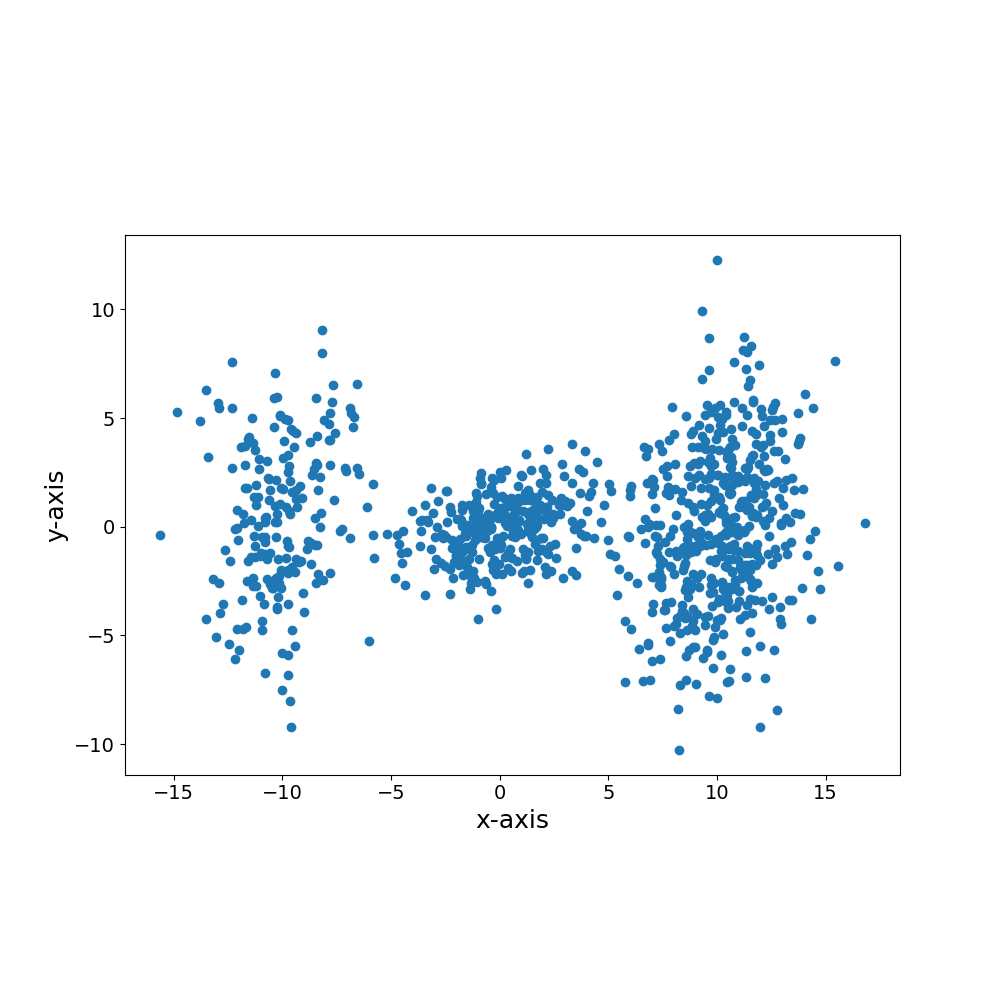

In [3]:
N = 1000

gmm_pdf = {}
# Likelihood of each distribution to be selected
gmm_pdf['priors'] = np.array([0.2, 0.3, 0.5]) 
# Number of components inferred from mixture weights
K = gmm_pdf['priors'].shape[0]
gmm_pdf['mu'] = np.array([[-10, 0],
                          [0, 0],
                          [10, 0]])  # Gaussian distributions means
gmm_pdf['Sigma'] = np.array([[[3, 1],
                              [1, 15]],
                             [[5, 1],
                              [1, 2]],
                             [[4, 1],
                              [1, 12]]])  # Gaussian distributions covariance matrices                    
                             
# Also generate validation dataset from GMM!
X, y = generate_data_from_gmm(N, gmm_pdf)

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(X[:, 0], X[:, 1])
ax.set_xlabel("x-axis")
ax.set_ylabel("y-axis")
ax.set_aspect('equal')

Now with the sklearn.mixture.GaussianMixture class we use the EM algorithm to estimate the parameters of a GMM that has the same number of components as the true GMM that generates the samples:

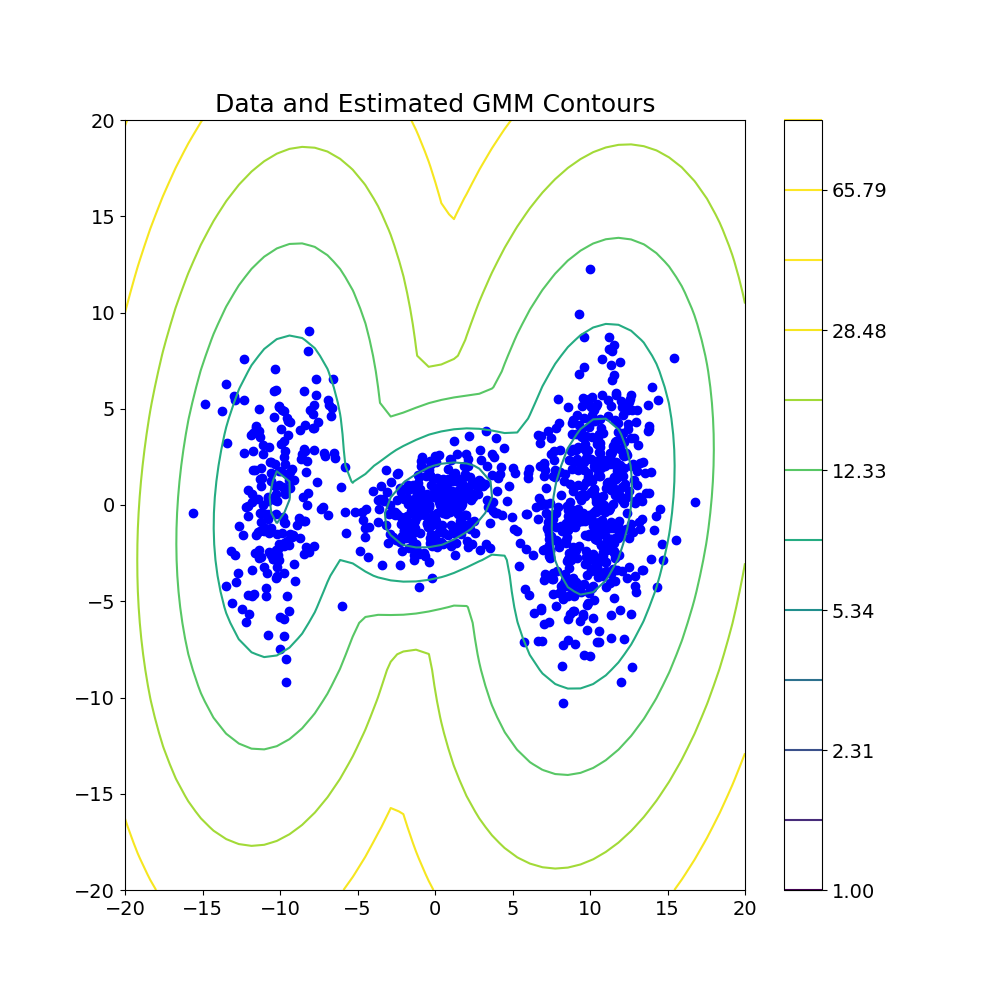

In [4]:
# Perform EM to estimate the parameters of the GMM using fit()
# Note that it's worthwhile looking into the class parameters
# e.g. for max iterations, convergence tolerance thresholds or regularization parameter, etc.
gmm = GaussianMixture(n_components=K, init_params='random_from_data', n_init=10, max_iter=400, tol=1e-3).fit(X)
# Can also initialize the above object's parameters with your own default values; instead of 'random_from_data'

# Display predicted scores by the model as a contour plot
xx, yy = np.meshgrid(np.linspace(-20.0, 20.0), np.linspace(-20.0, 20.0))
grid = np.array([xx.ravel(), yy.ravel()]).T
# Z matrix are the negative log likelihood (NLL) scores of the samples 
# Basically evaluating the GMM on the grid of samples to see how well it has been fit
Z = -gmm.score_samples(grid)
Z = Z.reshape(xx.shape)

# Create contour figure
fig = plt.figure(figsize=(10, 10))

# Plotting contours with a normalized log scale for the NLL of the grid samples
cs = plt.contour(xx, yy, Z, norm=LogNorm(vmin=1.0, vmax=30.0), levels=np.logspace(0, 2, 12))
# Color bar for contour to denote boundaries
cb = plt.colorbar(cs, extend='both')
    
plt.scatter(X[:, 0], X[:, 1], color='blue')

plt.title("Data and Estimated GMM Contours")
plt.axis('tight')
plt.show()

## GMM Cluster Assignment

Using the scikit-learn API, cluster assignment is then straightforward with the <b>GaussianMixture</b> class once the parameters have been "fit" via the EM algorithm. I will leave this as a task for you to solve.

Also a brief note between <b>hard</b> and <b>soft</b> cluster assignment. Assume the model parameters $\boldsymbol{\theta} = \left[\mathbf{a}, \{\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k\}\right]$ are available, then the "posterior membership probability" of sample $\mathbf{x}^{(i)}$ belonging to cluster $k$ is:

$$ p(z^{(i)} = k | \mathbf{x}^{(i)}, \boldsymbol{\theta}) = \frac{p(z^{(i)} = k | \boldsymbol{\theta}) p(\mathbf{x}^{(i)} | (z^{(i)} = k, \boldsymbol{\theta})}{\sum_{k'=1}^K p(z^{(i)} = k' | \boldsymbol{\theta}) p(\mathbf{x}^{(i)} | z^{(i)} = k', \boldsymbol{\theta})},$$

where this posterior probability is considered a "soft" (or <b>fuzzy</b>) assignment of samples to clusters, as the data points are scored (values in range $[0,1]$) rather than assigned a specific label. A higher posterior probability score indicates a stronger association of that sample to the cluster. This method of assignment offers the flexibility of assigning a single data point to multiple clusters, with varying levels of confidence.
On the other hand, a "hard" assignment using GMM clustering is to take the most probable cluster assignment:

$$ z^{(i)} = \mathop{\rm argmax}_k \left[ \log p(\mathbf{x}^{(i)} | z^{(i)} = k, \boldsymbol{\theta}) + \log p(z^{(i)} = k | \boldsymbol{\theta})  \right].$$

The above MAP clustering is viewed as <b>hard GMM clustering</b>.

Note that the discrete latent or hidden variable $z^{(i)} \in \{1, \ldots, K\}$ specifies the mixture component or cluster label. which responsible for generating data $\mathbf{x}^{(i)}$. In the [K-means example](k_means_clustering.ipynb), these labels were instead denoted as $c^{(i)}$, however as I mention above, $\mathbf{z}$ is a common variable symbol for latent variables.